imports

In [1]:
!pip install torch numpy matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os, math, time, json, random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# DONNEES

In [2]:
#importation données
equiv=pd.read_csv("../data/scenario_equiv.csv",sep=";", encoding="utf-8")
equiv = equiv.replace(',', '.', regex=True).astype(float)
equiv.columns = equiv.columns.str.replace(' ', '_')

/tmp/ipykernel_68320/550567033.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


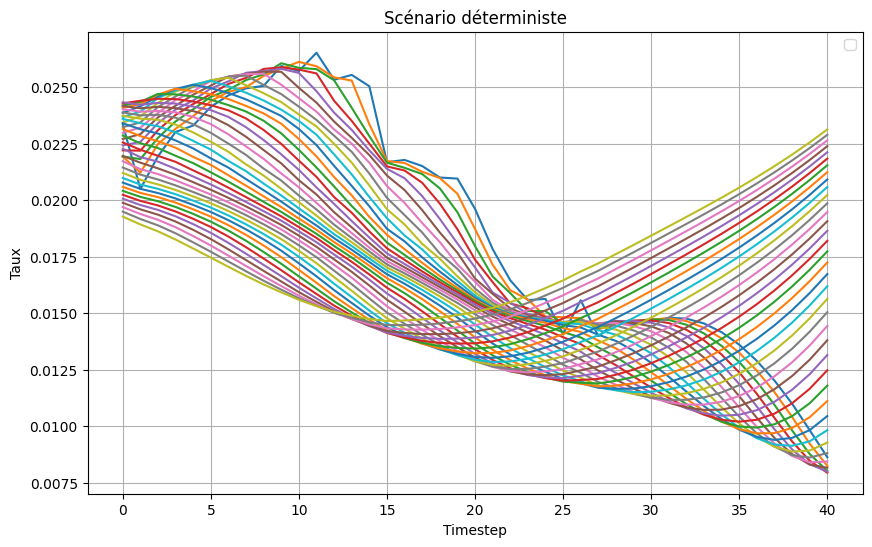

In [3]:
plt.figure(figsize=(10, 6))

X=np.arange(41)

# Tracer chaque colonne comme une courbe
for j in range(2,41):
    Y=[]
    for i in range(41):
        Y.append(equiv.iloc[i,j])
    plt.plot(X,Y)

plt.title('Scénario déterministe')
plt.xlabel('Timestep')
plt.ylabel('Taux')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
#importation données
data3000=pd.read_csv("../data/3000_scenariosSTO.csv",sep=";", encoding="utf-8")
data3000 = data3000.replace(',', '.', regex=True).astype(float)
data3000.columns = data3000.columns.str.replace(' ', '_')

In [5]:
#On reshape les données en (3000x41x40)
spot_cols = [col for col in data3000.columns if 'EUR_Nom_Spot_' in col]
spot_cols = sorted(spot_cols, key=lambda x: int(x.split('_')[-1]))
spot_data = data3000[spot_cols].values  # shape (123000, 40)

X_all = spot_data.reshape((3000, 41, 40))  # (N=3000, M=41, T=40)

/tmp/ipykernel_68320/3634183899.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


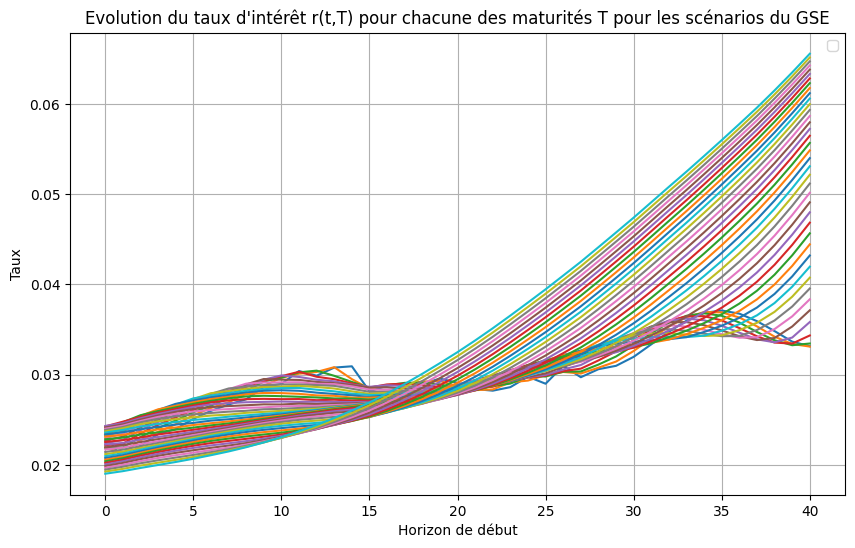

In [6]:
mean_paths = np.mean(X_all, axis=0)

# Supposons que mean_paths soit de forme (41, 40)
# mean_paths contient les 40 colonnes et 41 valeurs par colonne

plt.figure(figsize=(10, 6))

X=np.arange(41)

# Tracer chaque colonne comme une courbe
for i in range(40):
    Y=[]
    for j in range(41):
        Y.append(mean_paths[j][i])
    plt.plot(X,Y)

plt.title("Evolution du taux d'intérêt r(t,T) pour chacune des maturités T pour les scénarios du GSE")
plt.xlabel('Horizon de début')
plt.ylabel('Taux')
plt.legend()
plt.grid(True)
plt.show()

seed

In [7]:
torch.backends.cudnn.benchmark = True
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(s)

set_seed(42)
print("Device:", DEVICE)

Device: cuda


# IMPLEMENTATION DU GAN

Normalisation par maturité & Dataset

In [8]:
class PerMaturityNormalizer:
    """
    Normalise par maturité (dimension 1); stats calculées sur le set d'entraînement.
    Attend des tenseurs shape (N, 41, 40).
    """
    def fit(self, x_train: torch.Tensor):
        # moyenne/écart-type par maturité sur toutes les dates et scénarios
        # x_train: (N, M, T)
        self.mean = x_train.mean(dim=(0,2), keepdim=True)  # (1, M, 1)
        self.std = x_train.std(dim=(0,2), keepdim=True).clamp_min(1e-8)
        return self

    def transform(self, x: torch.Tensor) -> torch.Tensor:
        return (x - self.mean) / self.std

    def inverse_transform(self, x_norm: torch.Tensor) -> torch.Tensor:
        return x_norm * self.std + self.mean


class ScenarioDataset(Dataset):
    def __init__(self, x_tensor: torch.Tensor):
        assert x_tensor.dim() == 3, "attendu: (N, 41, 40)"
        self.x = x_tensor.float()

    def __len__(self): return self.x.size(0)

    def __getitem__(self, idx):
        return self.x[idx]

Modèles (G: MLP → 41×40, D: LSTM×2 → Sigmoïde)

In [9]:
M, T = 41, 40  # maturités, dates
LATENT_DIM = 128

class GeneratorMLP(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, hidden=512, depth=4, out_shape=(M, T)):
        super().__init__()
        layers = []
        in_dim = latent_dim
        for i in range(depth):
            layers += [nn.Linear(in_dim, hidden), nn.ReLU(inplace=True)]
            in_dim = hidden
        self.mlp = nn.Sequential(*layers)
        self.proj = nn.Linear(hidden, out_shape[0]*out_shape[1])
        self.out_shape = out_shape

        # init un peu plus stable
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                nn.init.zeros_(m.bias)

    def forward(self, z):
        h = self.mlp(z)
        x = self.proj(h)
        return x.view(-1, *self.out_shape)  # (B, 41, 40)


class DiscriminatorLSTM(nn.Module):
    def __init__(self, input_size=M, hidden=256, num_layers=2, dropout=0.3):
        super().__init__()
        # On lit la série dans le temps: on transpose en (B, T, M) → (seq_len=T, batch=B, features=M)
        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden, num_layers=num_layers,
            dropout=dropout, batch_first=True, bidirectional=False
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden, 1)

        # init
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
        nn.init.xavier_uniform_(self.fc.weight); nn.init.zeros_(self.fc.bias)

    def forward(self, x):  # x: (B, M, T) normalisé
        x = x.transpose(1, 2).contiguous()  # (B, T, M)
        out, _ = self.lstm(x)               # (B, T, H)
        h_last = out[:, -1, :]              # (B, H)
        h_last = self.dropout(h_last)
        logits = self.fc(h_last)            # (B, 1)
        prob = torch.sigmoid(logits)
        return prob, logits

Métriques simples (moy/var/corr) & validation

In [10]:
@torch.no_grad()
def compute_stats(x: torch.Tensor):
    """
    x: (N, M, T) en espace *dé-normalisé* idéalement.
    Retourne dict avec: mean_maturity(M), var_maturity(M), corr_intra_date(MxM) moyen sur T.
    """
    N, M_, T_ = x.shape
    # moyennes/variances par maturité (moyenne sur N et T)
    mean_m = x.mean(dim=(0,2))     # (M,)
    var_m  = x.var(dim=(0,2), unbiased=False)  # (M,)

    # corrélation intra-date: pour chaque t, corr(maturités) sur N échantillons
    corrs = []
    for t in range(T_):
        Xt = x[:,:,t]  # (N, M)
        Xt = Xt - Xt.mean(dim=0, keepdim=True)
        cov = (Xt.T @ Xt) / max(N-1, 1)  # (M, M)
        std = Xt.std(dim=0, keepdim=True).clamp_min(1e-12)
        corr = cov / (std.T @ std)
        corrs.append(corr.unsqueeze(0))
    corr_mean = torch.stack(corrs, dim=0).mean(dim=0)  # (M, M)
    return {"mean_m": mean_m, "var_m": var_m, "corr": corr_mean}

@torch.no_grad()
def stats_distance(stats_real, stats_gen):
    # MAE relatif pour mean/var ; Frobenius pour corr
    eps = 1e-12
    d_mean = (stats_real["mean_m"] - stats_gen["mean_m"]).abs() / (stats_real["mean_m"].abs() + eps)
    d_var  = (stats_real["var_m"]  - stats_gen["var_m"]).abs()  / (stats_real["var_m"].abs()  + eps)
    d_corr = torch.norm(stats_real["corr"] - stats_gen["corr"], p='fro') / torch.norm(stats_real["corr"], p='fro').clamp_min(eps)
    return {
        "mean_mae_rel": d_mean.mean().item(),
        "var_mae_rel": d_var.mean().item(),
        "corr_rel_frob": d_corr.item()
    }

DataLoaders + Normalisation

In [11]:
X_all = torch.tensor(X_all, dtype=torch.float32)

# Split indices : 70% train, 15% val, 15% test
N = X_all.shape[0]
n_train = int(0.7 * N)
n_val   = int(0.15 * N)
n_test  = N - n_train - n_val

X_train = X_all[:n_train]
X_val   = X_all[n_train:n_train+n_val]
X_test  = X_all[n_train+n_val:]

In [12]:
normalizer = PerMaturityNormalizer().fit(X_train)
X_train_n = normalizer.transform(X_train)
X_val_n   = normalizer.transform(X_val)
X_test_n  = normalizer.transform(X_test)

train_loader = DataLoader(ScenarioDataset(X_train_n), batch_size=64, shuffle=True, drop_last=True)
val_loader   = DataLoader(ScenarioDataset(X_val_n),   batch_size=64, shuffle=False)
test_loader  = DataLoader(ScenarioDataset(X_test_n),  batch_size=64, shuffle=False)

# Stats de référence (dans l'espace dé-normalisé)
stats_real_val  = compute_stats(X_val)
stats_real_test = compute_stats(X_test)

Entraînement GAN (BCE, Adam, dropout, clipping

In [13]:
G = GeneratorMLP(latent_dim=LATENT_DIM, hidden=512, depth=4).to(DEVICE)
D = DiscriminatorLSTM(input_size=M, hidden=256, num_layers=2, dropout=0.3).to(DEVICE)

lr_g, lr_d = 1e-4, 2e-4
opt_g = torch.optim.Adam(G.parameters(), lr=lr_g, betas=(0.5, 0.999))
opt_d = torch.optim.Adam(D.parameters(), lr=lr_d, betas=(0.5, 0.999))

bce = nn.BCELoss()

def smooth_labels(t, real=True, eps=0.1):
    if real:
        return torch.empty_like(t).uniform_(1.0 - eps, 1.0)
    else:
        return torch.empty_like(t).uniform_(0.0, eps)

def train_one_epoch(epoch, n_critic=1, clip_grad=1.0, label_smooth=0.1):
    G.train(); D.train()
    losses = {"d": [], "g": []}

    for real in train_loader:
        real = real.to(DEVICE)

        # === Update D ===
        for _ in range(n_critic):
            opt_d.zero_grad()

            # Réel
            y_real = smooth_labels(torch.ones(real.size(0), 1, device=DEVICE), True, label_smooth)
            p_real, _ = D(real)
            loss_real = bce(p_real, y_real)

            # Faux
            z = torch.randn(real.size(0), LATENT_DIM, device=DEVICE)
            fake = G(z).detach()
            y_fake = smooth_labels(torch.zeros(real.size(0), 1, device=DEVICE), False, label_smooth)
            p_fake, _ = D(fake)
            loss_fake = bce(p_fake, y_fake)

            loss_d = (loss_real + loss_fake)
            loss_d.backward()
            if clip_grad is not None:
                nn.utils.clip_grad_norm_(D.parameters(), clip_grad)
            opt_d.step()

        # === Update G ===
        opt_g.zero_grad()
        z = torch.randn(real.size(0), LATENT_DIM, device=DEVICE)
        fake = G(z)
        # G veut que D le prenne pour du réel
        y_trick = torch.ones(real.size(0), 1, device=DEVICE)
        p_fake, _ = D(fake)
        loss_g = bce(p_fake, y_trick)
        loss_g.backward()
        if clip_grad is not None:
            nn.utils.clip_grad_norm_(G.parameters(), clip_grad)
        opt_g.step()

        losses["d"].append(loss_d.item())
        losses["g"].append(loss_g.item())

    return {k: float(np.mean(v)) for k, v in losses.items()}


@torch.no_grad()
def evaluate(num_batches=5):
    G.eval(); D.eval()
    # on échantillonne autant de faux que le val set pour comparer les stats
    n = len(val_loader.dataset)
    bs = val_loader.batch_size
    acc = []
    for _ in range(math.ceil(n/bs)):
        z = torch.randn(bs, LATENT_DIM, device=DEVICE)
        fake_n = G(z)
        # dénormaliser pour comparer dans l'espace réel
        fake = normalizer.inverse_transform(fake_n.cpu())
        acc.append(fake)
    fake_all = torch.cat(acc, dim=0)[:n]  # (N_val, M, T)

    stats_gen_val = compute_stats(fake_all)
    dist = stats_distance(stats_real_val, stats_gen_val)

    # aussi une loss D rapide sur val (mélange real/fake)
    d_losses = []
    for real in val_loader:
        real = real.to(DEVICE)
        y_real = torch.ones(real.size(0), 1, device=DEVICE)
        p_real, _ = D(real)
        z = torch.randn(real.size(0), LATENT_DIM, device=DEVICE)
        fake = G(z)
        y_fake = torch.zeros(real.size(0), 1, device=DEVICE)
        p_fake, _ = D(fake)
        d_losses.append( bce(p_real, y_real).item() + bce(p_fake, y_fake).item() )
    d_val = float(np.mean(d_losses)) if d_losses else float('nan')

    return dist | {"d_val_bce": d_val}


Boucle d’entraînement + sauvegarde du meilleur G (selon stats)

In [14]:
EPOCHS = 100
BEST = {"score": float('inf'), "epoch": -1}
ckpt_dir = "." 
os.makedirs(ckpt_dir, exist_ok=True)
ckpt_path = os.path.join(ckpt_dir, "best_generator.pt")

history = []
for epoch in range(1, EPOCHS+1):
    tr = train_one_epoch(epoch, n_critic=1, clip_grad=1.0, label_smooth=0.1)
    ev = evaluate()
    score = ev["mean_mae_rel"] + ev["var_mae_rel"] + ev["corr_rel_frob"]  # score simple

    row = {"epoch": epoch} | tr | ev | {"score": score}
    history.append(row)

    print(f"[{epoch:03d}] D:{tr['d']:.4f} G:{tr['g']:.4f} | "
          f"mean={ev['mean_mae_rel']:.4f} var={ev['var_mae_rel']:.4f} corr={ev['corr_rel_frob']:.4f} | "
          f"D_val={ev['d_val_bce']:.4f} | score={score:.4f}")

    # early model selection
    if score < BEST["score"]:
        BEST.update({"score": score, "epoch": epoch})
        torch.save({"state_dict": G.state_dict(),
                    "latent_dim": LATENT_DIM,
                    "M": M, "T": T}, ckpt_path)

print("Meilleur epoch:", BEST)
print("G sauvegardé ici:", ckpt_path)

[001] D:1.2827 G:0.7494 | mean=0.3960 var=0.6848 corr=1.0000 | D_val=1.0237 | score=2.0808
[002] D:1.0591 G:1.0993 | mean=0.2836 var=0.5043 corr=1.0000 | D_val=1.3745 | score=1.7880
[003] D:1.1383 G:1.2212 | mean=0.6345 var=0.9000 corr=1.0000 | D_val=0.7975 | score=2.5346
[004] D:0.8333 G:1.5795 | mean=0.3595 var=0.7779 corr=1.0000 | D_val=0.9969 | score=2.1373
[005] D:1.2053 G:1.1008 | mean=0.2588 var=0.6797 corr=1.0000 | D_val=0.7665 | score=1.9384
[006] D:1.0148 G:1.5076 | mean=0.6973 var=0.8991 corr=1.0000 | D_val=0.5237 | score=2.5964
[007] D:1.1165 G:1.6004 | mean=0.4284 var=0.7579 corr=1.0000 | D_val=0.3687 | score=2.1862
[008] D:1.1973 G:1.5073 | mean=0.4227 var=1.0170 corr=1.0000 | D_val=0.4582 | score=2.4397
[009] D:0.8886 G:1.3454 | mean=0.3454 var=0.1624 corr=1.0000 | D_val=0.5693 | score=1.5077
[010] D:1.1754 G:1.4991 | mean=0.0966 var=0.3279 corr=1.0000 | D_val=0.5507 | score=1.4245
[011] D:0.9949 G:1.5395 | mean=0.2339 var=0.5179 corr=1.0000 | D_val=0.8432 | score=1.7518

Génération finale & évaluation sur test

In [15]:
# Charger le meilleur G si besoin
if os.path.exists(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=DEVICE)
    G.load_state_dict(ckpt["state_dict"])
G.eval()

@torch.no_grad()
def generate_scenarios(n_samples=256, batch_size=128):
    outs = []
    for i in range(0, n_samples, batch_size):
        bs = min(batch_size, n_samples - i)
        z = torch.randn(bs, LATENT_DIM, device=DEVICE)
        fake_n = G(z).cpu()
        fake = normalizer.inverse_transform(fake_n)  # revenir aux unités réelles
        outs.append(fake)
    return torch.cat(outs, dim=0)  # (n_samples, 41, 40)

# Générer N scénarios et comparer aux stats TEST
N_GEN = len(test_loader.dataset)
gen_test = generate_scenarios(N_GEN)
stats_gen_test = compute_stats(gen_test)
dist_test = stats_distance(stats_real_test, stats_gen_test)
print("Écarts TEST:", json.dumps(dist_test, indent=2))

# Optionnel: sauvegarde
np.save(os.path.join(ckpt_dir, "generated_scenarios_test.npy"), gen_test.numpy())
print("Scénarios générés:", os.path.join(ckpt_dir, "generated_scenarios_test.npy"))

Écarts TEST: {
  "mean_mae_rel": 0.09248123317956924,
  "var_mae_rel": 0.19563470780849457,
  "corr_rel_frob": 0.9999998807907104
}
Scénarios générés: ./generated_scenarios_test.npy


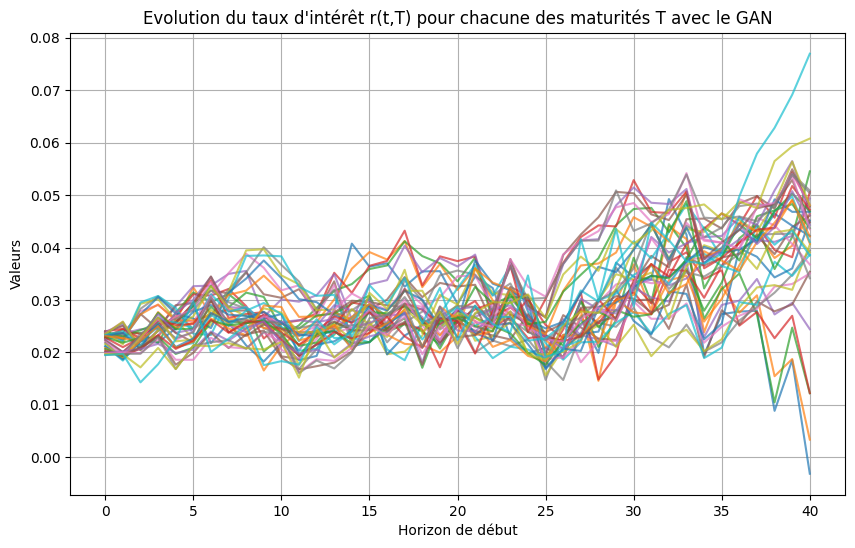

In [16]:
# Moyenne des scénarios générés (sur tous les N_GEN)
mean_paths_gen = gen_test.mean(dim=0).numpy()  # (41, 40)

plt.figure(figsize=(10, 6))

X = np.arange(41)

# Tracer chaque colonne (chaque date) comme une courbe de terme
for i in range(mean_paths_gen.shape[1]):  # 40 colonnes
    Y = mean_paths_gen[:, i]  # valeurs sur 41 maturités
    plt.plot(X, Y, alpha=0.7)

plt.title("Evolution du taux d'intérêt r(t,T) pour chacune des maturités T avec le GAN")
plt.xlabel("Horizon de début")
plt.ylabel("Valeurs")
plt.grid(True)
plt.show()
